# Stochastic Variational Inference for Gaussian Process Regression

In [1]:
from IPython.display import clear_output

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from jax.experimental import optimizers
from gpjax.datasets import CustomDataset, NumpyLoader
from gpjax.kernels import SquaredExponential
from gpjax.parameters import build_constrain_params
from gpjax.mean_functions import Zero
from gpjax.likelihoods import Gaussian
from gpjax.models import SVGP
from torch.utils.data import DataLoader

key = jax.random.PRNGKey(10)

## Data Set
Let's create a simple dataset.

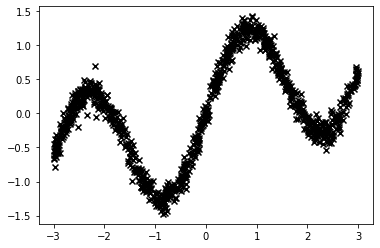

In [2]:
input_dim = 1
output_dim = 1
num_data = 1000
num_test = 1000
num_inducing = 50
batch_size = 60

def func(X):
    return np.sin(2*X)+ 0.3 * X + np.random.normal(0, 0.1, X.shape)

X = np.random.uniform(-3.0, 3.0, (num_data, input_dim))
Y = func(X)

plt.scatter(X[:,0], Y[:,0], marker="x", color="k")
plt.show()

And some test inputs for plotting our GP.

In [3]:
Xtest = jnp.sort(jax.random.uniform(key, shape=(num_test, input_dim), minval=-5, maxval=5), 0)

## Defining the SVGP
Let's create a SVGP model with a squared exponential kernel, Gaussian likelihood and zero mean function.

In [4]:
kernel = SquaredExponential(lengthscales=jnp.ones(input_dim, dtype=jnp.float64), variance=2.0)
likelihood = Gaussian(variance=3.0)
mean_function = Zero(output_dim=output_dim)

Let's initialise the inducing inputs and then use them to instantiate the SVGP class. If no `q_mu` or `q_sqrt` is specified then the SVGP class will automatically generate them.

In [5]:
inducing_variable = jax.random.uniform(key=key, shape=(num_inducing, input_dim)) * (X.max() - X.min()) + X.min()
svgp = SVGP(kernel, likelihood, inducing_variable, mean_function, num_latent_gps=output_dim)

### Parameters
Now that we have our SVGP class we would like to learn the parameters from observations. In order to do this, we must first get the dictionary of parameters associated with the model. 

In [6]:
svgp_params = svgp.get_params()
print(svgp_params.keys())

dict_keys(['kernel', 'likelihood', 'mean_function', 'inducing_variable', 'q_mu', 'q_sqrt'])


We could alternatively define our own dictionary of parameters instead of using the SVGP class to handle parameter initialisation.

### Parameter Transformations
Many of the parameters we wish to optimise are strictly positive and we handle this via bijective transformations. GPJax requires a dictionary of bijective transformations (with the same pytree structure as the parameters dictionary)
where each leaf contains the transformation (tfp.bijectives.Bijective) for the associated parameter.
The `build_constrain_params` function should then be use to generate a function that maps each element of the parameter dictionary from the space of real numbers to its associated transformed space. The resulting function is used to build the objective function.

In [7]:
svgp_transforms = svgp.get_transforms()
constrain_params = build_constrain_params(svgp_transforms)

## Plotting
Let's create a helper function for plotting the model for a given set of parameters.

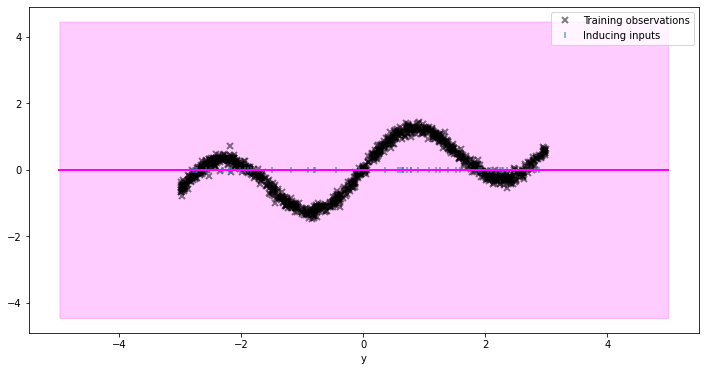

In [15]:
def plot_model(params):
    params = constrain_params(params)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, "kx", mew=2, alpha=0.5, label="Training observations")
    plt.plot(params["inducing_variable"], jnp.zeros([num_inducing, input_dim]), "|", mew=2, alpha=0.5, label="Inducing inputs")
    mean, var = svgp.predict_y(params, Xtest, full_cov=False)
    plt.plot(Xtest, mean, "magenta", lw=2)
    plt.fill_between(
        Xtest[:, 0],
        mean[:, 0] - 1.96 * jnp.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * jnp.sqrt(var[:, 0]),
        color="magenta",
        alpha=0.2,
    )
    plt.xlabel("x")
    plt.xlabel("y")
    plt.legend()
    plt.show()
plot_model(svgp_params)

## Optimiser
Now that we have defined our model, we wish to learn the optimal set of hyperparameters and variational parameters given a data set. This is achieved by maximising a lower bound on the marginal likelihood (Evidence Lower BOund ELBO).
Let's use the Adam optimiser from JAX's experimental module.

In [9]:
learning_rate = 1e-3
# learning_rate = 1e-2
num_epochs = 900

# Create optimizer
opt_init, opt_update, get_params = optimizers.adam(learning_rate)

Our objective function should accept the dictionary of parameters and a batch of data. Let's build our objective function by passing it the parameter transformations and the static arguments (just `num_data` in this case). We then use this objective to define a training step for the optimiser.

In [10]:
elbo = svgp.build_elbo(constrain_params=constrain_params, num_data=num_data)

def negative_elbo(params, batch):
    return - elbo(params, batch)

@jax.jit
def train_step(step_i, opt_state, batch):
    params = get_params(opt_state)
    loss, grads = jax.value_and_grad(negative_elbo, argnums=0)(params, batch)
    return loss, opt_update(step_i, grads, opt_state)

We use PyTorch's Dataset and DataLoader with a few alterations to make it work with NumPy. The NumpyLoader class enables us to easily setup a dateset for iterating over batches.

In [11]:
data = (X, Y)
training_data = CustomDataset(X, Y)
train_dataloader = NumpyLoader(training_data, batch_size=batch_size, shuffle=True)

Let's run the optimiser and plot the mean ELBO every 20 epochs.

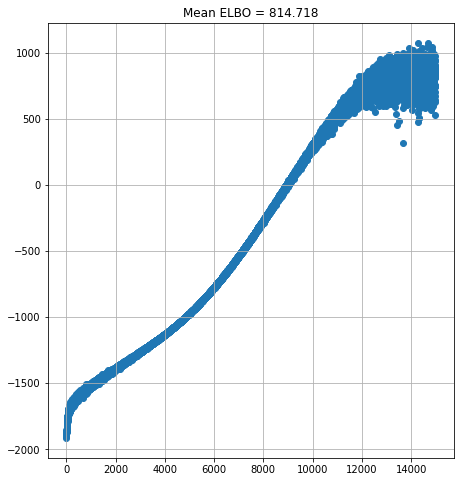

In [12]:
opt_state = opt_init(svgp_params)
loss_history = []
for epoch in range(num_epochs):
    for batch in train_dataloader:  # iterate over batches
        loss, opt_state = train_step(epoch, opt_state, batch)
        params = get_params(opt_state)
        loss_history.append(loss.item())

    if epoch % 20 == 0:
        clear_output(True)
        plt.figure(figsize=[16, 8])
        plt.subplot(1, 2, 1)
        plt.title("Mean ELBO = %.3f" % -jnp.mean(jnp.array(loss_history[-32:])))
        plt.scatter(jnp.arange(len(loss_history)), jnp.array(loss_history)*-1.0)
        plt.grid()
        plt.show()

Let's plot the model with the optimised parameters.

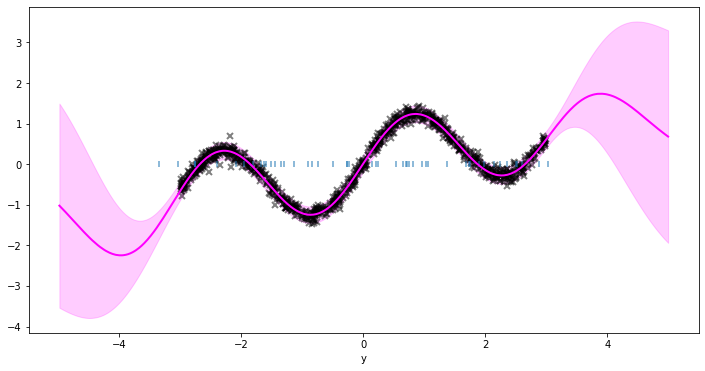

In [13]:
params = get_params(opt_state)
plot_model(params)